In [1]:
import gffpandas.gffpandas as gffpd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
WORKDIR = '/storage/homefs/kk22w918/Assembly'

In [3]:
# Load the EDTA output gff file
annotation = gffpd.read_gff3(os.path.join(WORKDIR, '5-TE', 'pilon-flye.fasta.mod.EDTA.TEanno.gff3'))
annotation_df = annotation.attributes_to_columns()
print(annotation_df.head())

          seq_id source                       type  start   end  score strand  \
0  contig_1_pilo   EDTA    L1_LINE_retrotransposon    261  2072   3157      +   
1  contig_1_pilo   EDTA       CACTA_TIR_transposon   4619  4907    784      -   
2  contig_1_pilo   EDTA  Gypsy_LTR_retrotransposon   5166  6042   3701      +   
3  contig_1_pilo   EDTA  Gypsy_LTR_retrotransposon   6045  8565  10912      +   
4  contig_1_pilo   EDTA  Gypsy_LTR_retrotransposon   8566  8857   2091      +   

  phase                                         attributes Classification  \
0     .  ID=TE_homo_0;Name=TE_00000693;Classification=L...        LINE/L1   
1     .  ID=TE_homo_1;Name=TE_00000311;Classification=D...        DNA/DTC   
2     .  ID=TE_homo_2;Name=TE_00000055_LTR;Classificati...      LTR/Gypsy   
3     .  ID=TE_homo_3;Name=TE_00000098_INT;Classificati...      LTR/Gypsy   
4     .  ID=TE_homo_4;Name=TE_00000475_INT;Classificati...      LTR/Gypsy   

   ... Identity    Method             Name Parent 

In [24]:
# Group the contigs/scaffold based on TE count
grouped_gff = annotation_df.groupby('seq_id').count().sort_values(by='source', key=lambda x: -x)
largest_scaff = grouped_gff.index[1]
print(f'Most TE Rich Scaffold/Contig: {largest_scaff}')

Most TE Rich Scaffold/Contig: contig_4_pilo


In [25]:
# Filter whole genome gff with values in largest scaffold
largest_scaff_df = annotation_df[annotation_df.seq_id == largest_scaff]
print(largest_scaff_df.head())

             seq_id source                    type  start   end score strand  \
1359  contig_4_pilo   EDTA                helitron   1608  2024   303      +   
1360  contig_4_pilo   EDTA                helitron   3934  4143   311      +   
1361  contig_4_pilo   EDTA                helitron   4310  4541   370      +   
1362  contig_4_pilo   EDTA  Mutator_TIR_transposon   4606  4990  2334      +   
1363  contig_4_pilo   EDTA  Mutator_TIR_transposon   6665  7073  1042      +   

     phase                                         attributes Classification  \
1359     .  ID=TE_homo_1200;Name=TE_00000514;Classificatio...   DNA/Helitron   
1360     .  ID=TE_homo_1201;Name=TE_00000514;Classificatio...   DNA/Helitron   
1361     .  ID=TE_homo_1202;Name=TE_00000514;Classificatio...   DNA/Helitron   
1362     .  ID=TE_homo_1203;Name=TE_00000332;Classificatio...        DNA/DTM   
1363     .  ID=TE_homo_1204;Name=TE_00000332;Classificatio...        DNA/DTM   

      ... Identity    Method         N

In [26]:
# Get clades 
clades = ['LTR/unknown', 'LTR/Gypsy', 'LINE/L1', 'LTR/Copia', 'DNA/Helitron']
n_clades = len(clades)
print(f'Number of clades: {n_clades}, Clades: {clades}')

# Binning
max_bp = np.max(largest_scaff_df.start)
max_bp_floor = 1e6 * float(max_bp)/1e6
max_bin = int(max_bp/1e6)
bins = list(range(max_bin))
bin_labels = list(map(lambda x: f'{x}-{x+1}Mbp', bins))


Number of clades: 5, Clades: ['LTR/unknown', 'LTR/Gypsy', 'LINE/L1', 'LTR/Copia', 'DNA/Helitron']


In [27]:
# Create bins for clades
bin_matrix = np.zeros((n_clades, max_bin))
for clade_idx, clade in enumerate(clades):
    for bin in bins:
        bin_start = bin * 1e6
        bin_end = bin_start + 1e6
        clade_filter = largest_scaff_df.Classification==clade
        bin_start_filter = largest_scaff_df.start>=bin_start
        bin_end_filter = largest_scaff_df.start<bin_end
        clade_bin_count = len(largest_scaff_df[clade_filter & bin_start_filter & bin_end_filter])
        bin_matrix[clade_idx,bin] = clade_bin_count

In [28]:
print(bin_matrix)

[[ 13.  19.   0.   1.   0.   1.   0.   6.   3.   6.]
 [100.  11.   1.   0.   0.   7.   2.   8.   0.   1.]
 [ 35.  20.  15.   9.   3.   7.   5.   0.   3.   2.]
 [ 34.  13.   9.  11.   2.   0.   5.   7.   3.   3.]
 [262. 178.  98.  60.  31.  45.  12.  51.  27.  36.]]


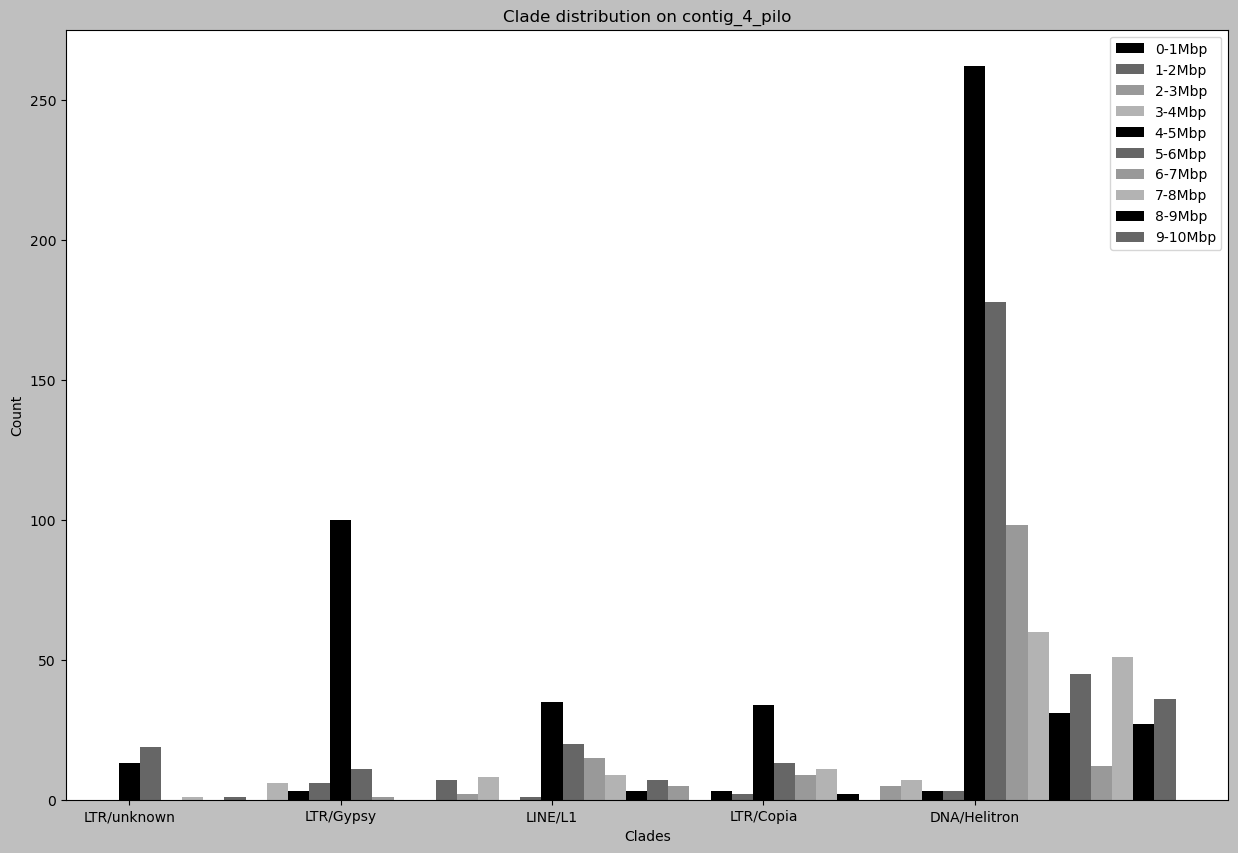

In [29]:
# Make a bar plot of TE counts vs contig location
plt.style.use('grayscale')

fig, ax = plt.subplots(figsize=(15,10))
X_axis = np.arange(n_clades)

for bin in bins:
    bin_values = bin_matrix[:,bin]
    ax.bar(X_axis + 0.1*bin, bin_values, 0.1, label=bin_labels[bin])

plt.xticks(X_axis, clades) 
plt.xlabel("Clades") 
plt.ylabel("Count") 
plt.title(f"Clade distribution on {largest_scaff}") 
plt.legend()
plt.savefig(os.path.join(WORKDIR, '5-TE', 'Accessions', f'{largest_scaff}_dist.png')) 
plt.show() 